In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install split-folders[full]

In [ ]:
import splitfolders
import os

# Define the input folder
input_folder = '/content/drive/MyDrive/archive/bloodcells_dataset'

# Check the number of files and directories
for root, dirs, files in os.walk(input_folder):
    print(f"Found {len(dirs)} directories and {len(files)} files in {root}")

# Split the dataset
splitfolders.ratio(input_folder, output="dataset",
                   seed=42, ratio=(.7, .2, .1),
                   group_prefix=None)

# Verify the output structure
output_folder = "dataset"
for root, dirs, files in os.walk(output_folder):
    print(f"Found {len(dirs)} directories and {len(files)} files in {root}")


Found 8 directories and 0 files in /content/drive/MyDrive/archive/bloodcells_dataset
Found 0 directories and 3375 files in /content/drive/MyDrive/archive/bloodcells_dataset/neutrophil
Found 0 directories and 1216 files in /content/drive/MyDrive/archive/bloodcells_dataset/lymphocyte
Found 0 directories and 1551 files in /content/drive/MyDrive/archive/bloodcells_dataset/erythroblast
Found 0 directories and 1420 files in /content/drive/MyDrive/archive/bloodcells_dataset/monocyte
Found 0 directories and 2368 files in /content/drive/MyDrive/archive/bloodcells_dataset/platelet
Found 0 directories and 2895 files in /content/drive/MyDrive/archive/bloodcells_dataset/ig
Found 0 directories and 1218 files in /content/drive/MyDrive/archive/bloodcells_dataset/basophil
Found 0 directories and 3157 files in /content/drive/MyDrive/archive/bloodcells_dataset/eosinophil


Copying files: 17200 files [08:03, 35.55 files/s] 

Found 3 directories and 0 files in dataset
Found 8 directories and 0 files in dataset/val
Found 0 directories and 243 files in dataset/val/basophil
Found 0 directories and 284 files in dataset/val/monocyte
Found 0 directories and 631 files in dataset/val/eosinophil
Found 0 directories and 310 files in dataset/val/erythroblast
Found 0 directories and 675 files in dataset/val/neutrophil
Found 0 directories and 579 files in dataset/val/ig
Found 0 directories and 243 files in dataset/val/lymphocyte
Found 0 directories and 473 files in dataset/val/platelet
Found 8 directories and 0 files in dataset/train
Found 0 directories and 852 files in dataset/train/basophil
Found 0 directories and 993 files in dataset/train/monocyte
Found 0 directories and 2209 files in dataset/train/eosinophil
Found 0 directories and 1085 files in dataset/train/erythroblast
Found 0 directories and 2362 files in dataset/train/neutrophil
Found 0 directories and 2026 files in dataset/train/ig
Found 0 directories and 851

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from warnings import filterwarnings

# Suppress warnings
filterwarnings('ignore')


In [ ]:
root_dir = '/content/drive/MyDrive/archive/bloodcells_dataset'

# Classes
print("-- Labels --")
for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    print(class_name)

-- Labels --
neutrophil
lymphocyte
erythroblast
monocyte
platelet
ig
basophil
eosinophil


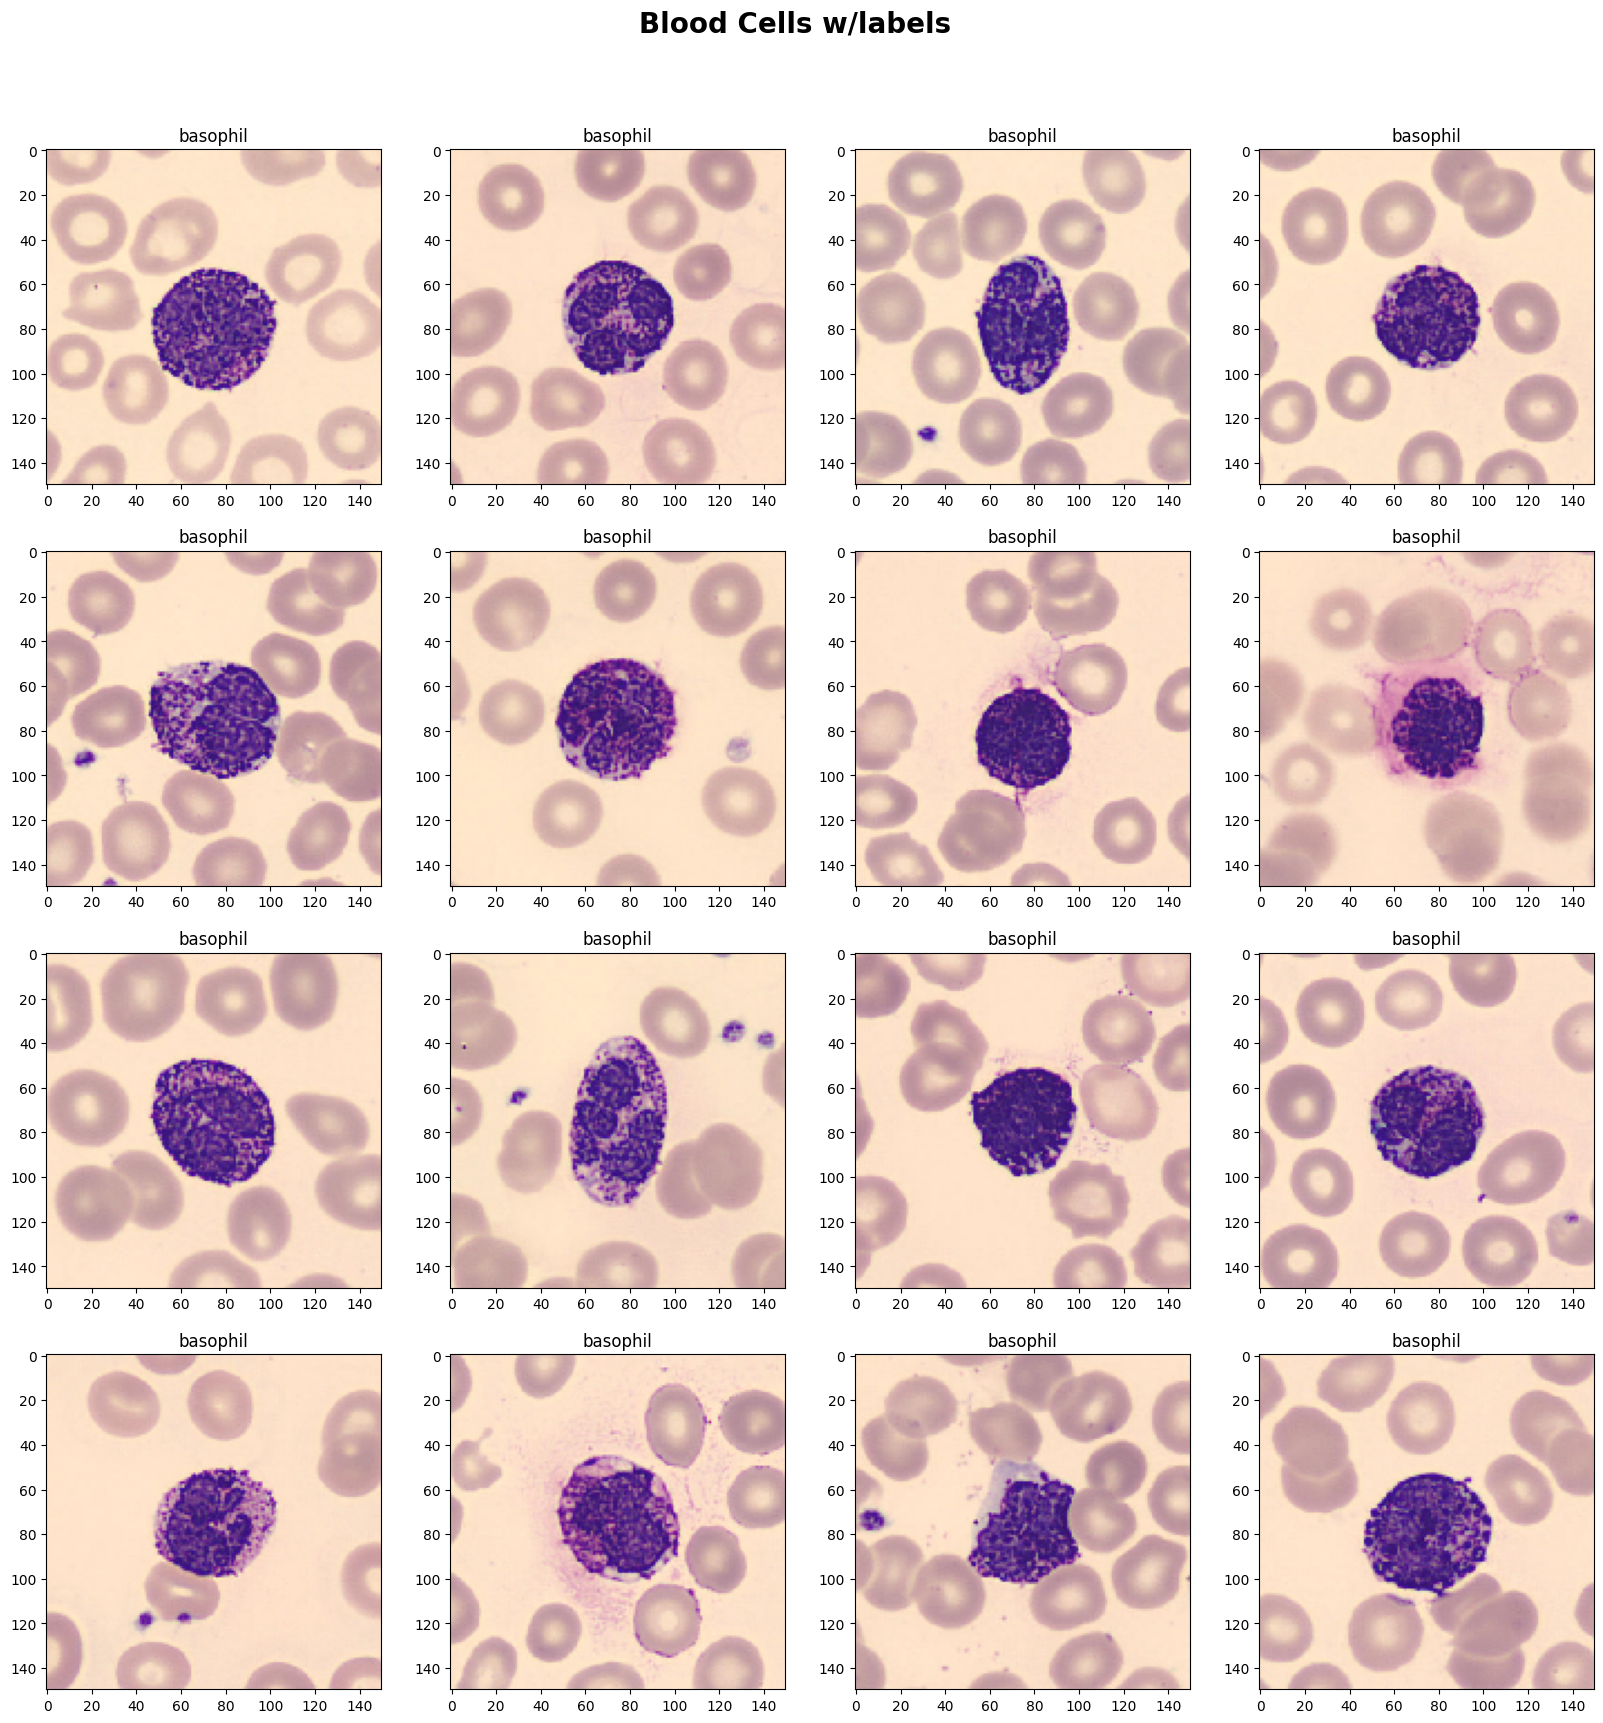

In [ ]:
from tensorflow.keras.preprocessing import image

# List of class names
class_names = sorted(os.listdir(root_dir))

# List of image paths
image_paths = []
for class_name in class_names:
    class_dir = os.path.join(root_dir, class_name)
    image_names = os.listdir(class_dir)
    for image_name in image_names:
        image_path = os.path.join(class_dir, image_name)
        image_paths.append(image_path)

# Plot some images to visually check
plt.figure(figsize=(20, 20))
plt.suptitle('Blood Cells w/labels', color='black', fontsize=20, fontweight='bold', x=0.5, y=0.95, ha='center', va='top')
for i in range(16):
    img = image.load_img(image_paths[i], target_size=(150, 150))
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    label = os.path.basename(os.path.dirname(image_paths[i]))
    plt.title("{}".format(label), color='black', fontsize=12)
    plt.axis('on')
plt.show()


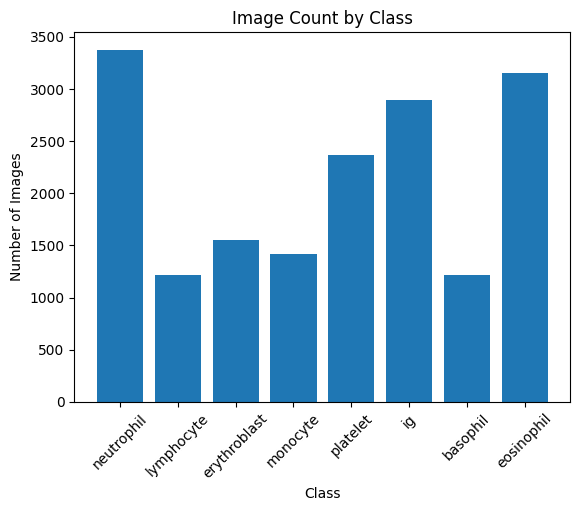

In [ ]:
# Count images in each class
class_counts = {}
for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    num_images = len(os.listdir(class_dir))
    class_counts[class_name] = num_images

# Plot class distribution
plt.bar(range(len(class_counts)), list(class_counts.values()), tick_label=list(class_counts.keys()))
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Image Count by Class')
plt.xticks(rotation=45)
plt.show()


In [ ]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    image_size=(224, 224),
    validation_split=0.2,
    subset='both',
    label_mode="categorical",
    seed=42,
    batch_size=32,
    shuffle=True
)

# Split dataset into train and validation sets
num_elements = len(train_ds)
train_size = int(0.8 * num_elements)
val_dataset = train_ds.skip(train_size).prefetch(tf.data.AUTOTUNE)
train_dataset = train_ds.take(train_size).prefetch(tf.data.AUTOTUNE)

# Check length
print(len(train_dataset), len(val_dataset), len(test_ds))


Found 17200 files belonging to 8 classes.
Using 13760 files for training.
Using 3440 files for validation.
344 86 108


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

# Download the pretrained resnet model and save it as a layer
feature_extraction_layer = ResNet50(include_top=False, input_shape=(224, 224, 3))

# Freeze all layers of base model
feature_extraction_layer.trainable = False

model = feature_extraction_layer.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.2)(model)
model = tf.keras.layers.Dense(8, activation='softmax')(model)
model = tf.keras.models.Model(inputs=feature_extraction_layer.input, outputs=model)

model.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [ ]:
# Compile the model with the appropriate loss function
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


In [ ]:
# Define the checkpoint path
checkpoint_path = "/content/drive/MyDrive/archive/model_best.keras"

# Create a callback to save the model with the best validation performance
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=2,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

# Create a callback to stop training early if no improvement in validation
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,         # Number of epochs without improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights from the epoch with the best validation performance
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001,
                              mode='auto', verbose=1)


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback, reduce_lr]
)


Epoch 1/10
344/344 [==============================] - ETA: 0s - loss: 0.9437 - accuracy: 0.6759
Epoch 1: val_accuracy improved from -inf to 0.83212, saving model to /content/drive/MyDrive/archive/model_best.keras
344/344 [==============================] - 2135s 6s/step - loss: 0.9437 - accuracy: 0.6759 - val_loss: 0.5180 - val_accuracy: 0.8321 - lr: 0.0010
Epoch 2/10
344/344 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.8351
Epoch 2: val_accuracy improved from 0.83212 to 0.89099, saving model to /content/drive/MyDrive/archive/model_best.keras
344/344 [==============================] - 89s 255ms/step - loss: 0.5043 - accuracy: 0.8351 - val_loss: 0.3656 - val_accuracy: 0.8910 - lr: 0.0010
Epoch 3/10
344/344 [==============================] - ETA: 0s - loss: 0.4129 - accuracy: 0.8674
Epoch 3: val_accuracy improved from 0.89099 to 0.90007, saving model to /content/drive/MyDrive/archive/model_best.keras
344/344 [==============================] - 91s 263ms/step - lo

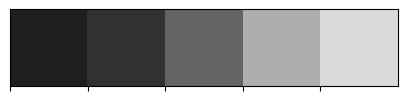

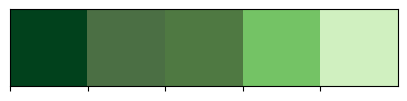

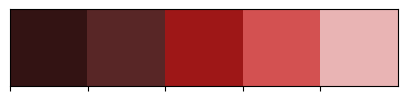

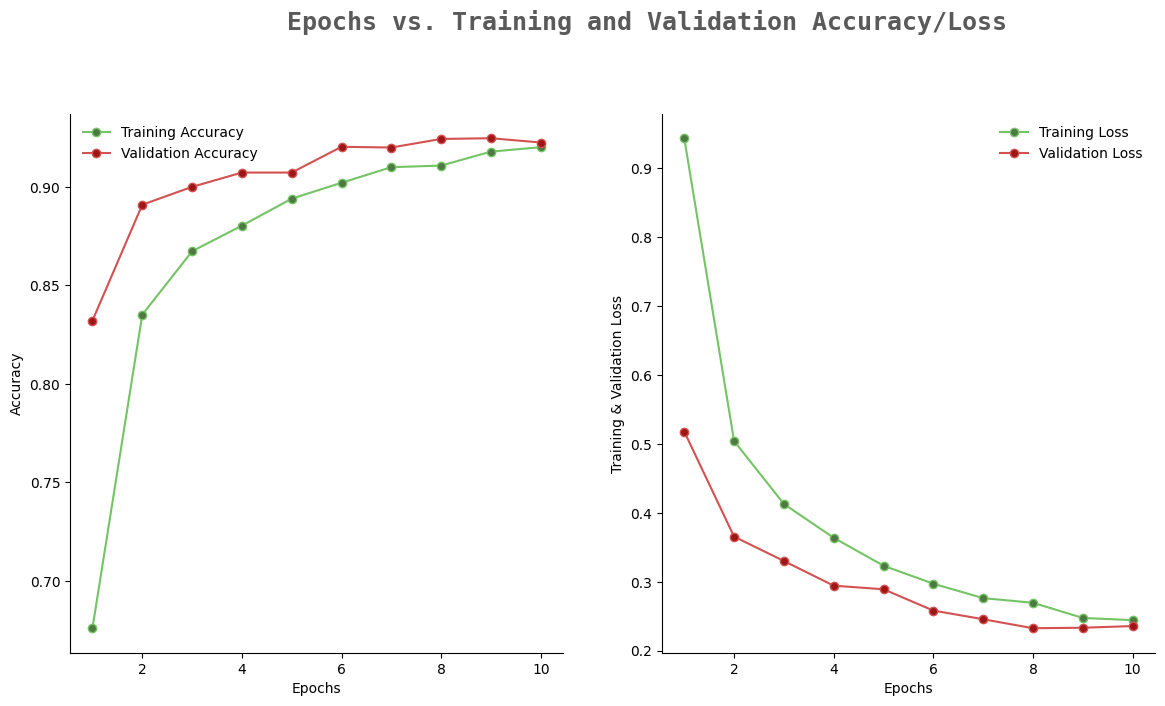

In [ ]:
# Plot training history
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C', '#4B6F44', '#4F7942', '#74C365', '#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

# Get training history data
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Create a list of epochs
epochs = range(1, len(train_acc) + 1)

# Create the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Configure the figure title
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=1, x=0.28, alpha=0.8)

# Configure plot styles
sns.despine()

# Plot training and validation accuracy
ax[0].plot(epochs, train_acc, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

# Plot training and validation loss
ax[1].plot(epochs, train_loss, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Loss')
ax[1].plot(epochs, val_loss, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

# Show the figure
plt.show()


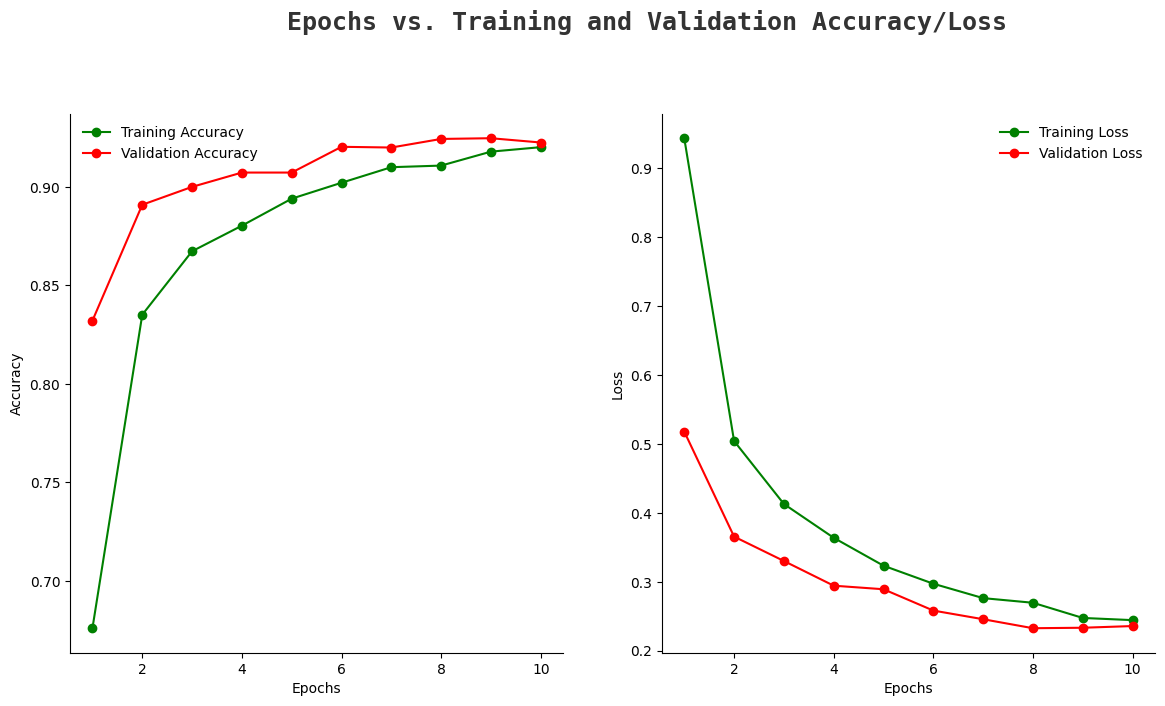

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold', fontname='monospace', color='black', y=1, x=0.28, alpha=0.8)

sns.despine()

ax[0].plot(epochs, train_acc, marker='o', markerfacecolor='green', color='green', label='Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o', markerfacecolor='red', color='red', label='Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, marker='o', markerfacecolor='green', color='green', label='Training Loss')
ax[1].plot(epochs, val_loss, marker='o', markerfacecolor='red', color='red', label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()


108/108 [==============================] - 417s 4s/step


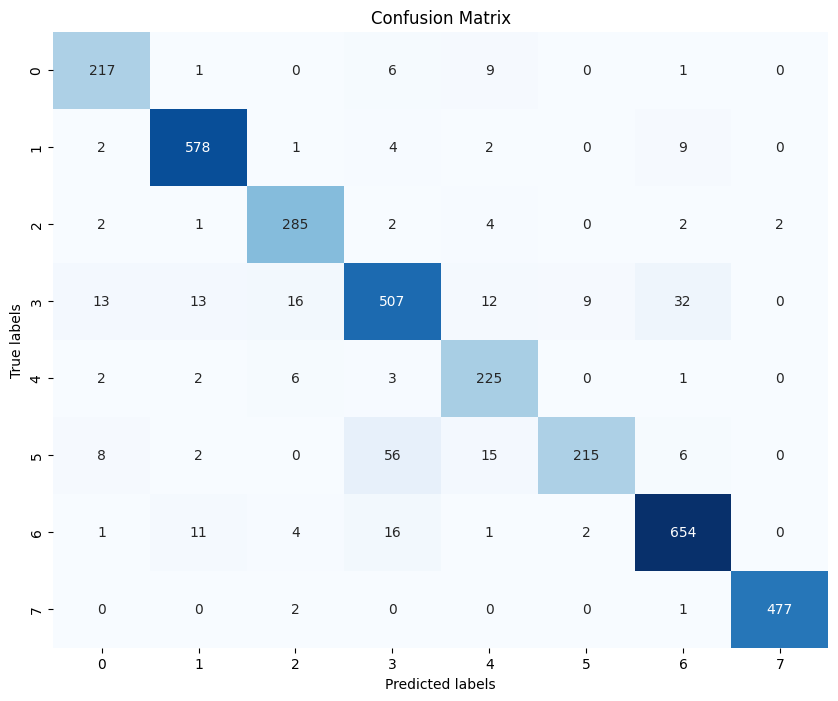

ROC AUC Score: 0.9948541078799671


In [ ]:
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

true_labels = np.concatenate([y for x, y in test_ds], axis=0)
true_labels_classes = np.argmax(true_labels, axis=1)

conf_matrix = confusion_matrix(true_labels_classes, predicted_classes)
roc_auc = roc_auc_score(true_labels_classes, predictions, multi_class='ovr')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("ROC AUC Score:", roc_auc)


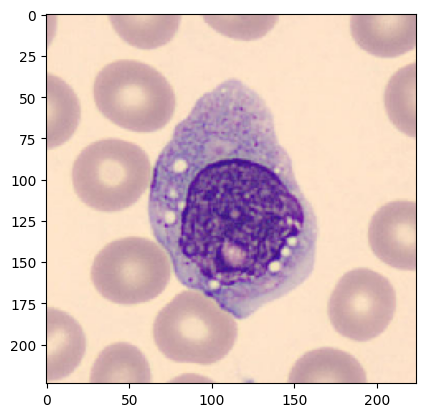

1/1 [==============================] - 0s 23ms/step
Predicted class: ig


In [ ]:
img_path = '/content/drive/MyDrive/archive/bloodcells_dataset/monocyte/MO_103089.jpg'  # Update this path to your image path

img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

predicted_class_name = class_names[predicted_class]

print(f'Predicted class: {predicted_class_name}')
